In [7]:
!pip install --upgrade pip
!pip install seaborn --upgrade
import seaborn as sns
print(sns.__version__)

     |████████████████████████████████| 1.5 MB 858 kB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.3.1
    Uninstalling pip-20.3.1:
      Successfully uninstalled pip-20.3.1
  Using cached seaborn-0.11.1-py3-none-any.whl (285 kB)
     |████████████████████████████████| 283 kB 851 kB/s eta 0:00:01
0.11.1


Importing modules for analysis

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

Importing modules for maps

In [9]:
import geopandas as gpd
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

Data import

In [39]:
df = pd.read_csv('../input/new-york-city-airbnb-open-data/AB_NYC_2019.csv')
ny_map = plt.imread('../input/new-york-city-airbnb-open-data/New_York_City_.png', 0)

In [40]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


# Preprocessing

In [41]:
print(f'There are {df.shape[1]} columns and {df.shape[0]} rows total in a dataset')

There are 16 columns and 48895 rows total in a dataset


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

We can see, that we missing some of the information about hosts and reviews. We can decide later what we are going to do aabout that.

In [43]:
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


Some of the prices are set to 0. Which doesnt make any sense. Unfortunately we cannot assume price. So we will remove it. Also there are suspiciously large difference between 3rd and 4th quartiles, which need to be explored further.

In [44]:
print(f'{len(df[df.price == 0])} rows were removes')
print(f"Difference between 3rd and 4th quartiles: {df.price.describe()['max'] - df.price.describe()['75%']}")
df = df[df.price > 0]

11 rows were removes
Difference between 3rd and 4th quartiles: 9825.0


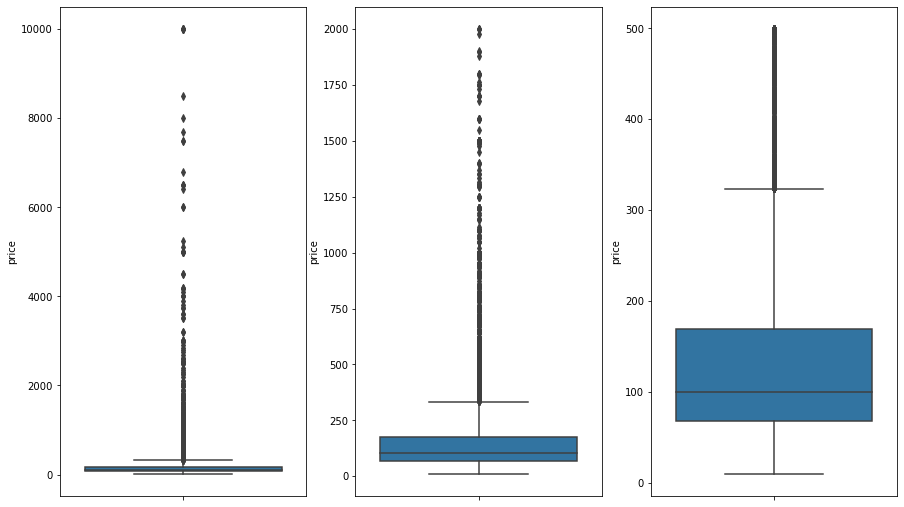

In [51]:
fig, axs = plt.subplots(ncols=3, figsize=(15,9))
sns.boxplot(y='price', ax=axs[0], data=df)
sns.boxplot(y='price', ax=axs[1], data=df[df.price < 2000])
sns.boxplot(y='price', ax=axs[2], data=df[df.price < 500])

Unfortunately we need to cut luxury appartemnts out of the study. They skewing data a lot and will be impacting our future study. Just in case we will need them. We gonna store them into separate data frame.

In [52]:
df_lux = df[df.price > 500]
print(f'{len(df_lux)} rows were removes')
df = df[df.price <= 500]

1044 rows were removes


# Price

In [58]:
print(f'Our average price now is {round(df.price.mean())} down from 153 calculated before.')

Our average price now is 132 down from 153 calculated before.


Lets start analysis by looking at the prie column in more details.

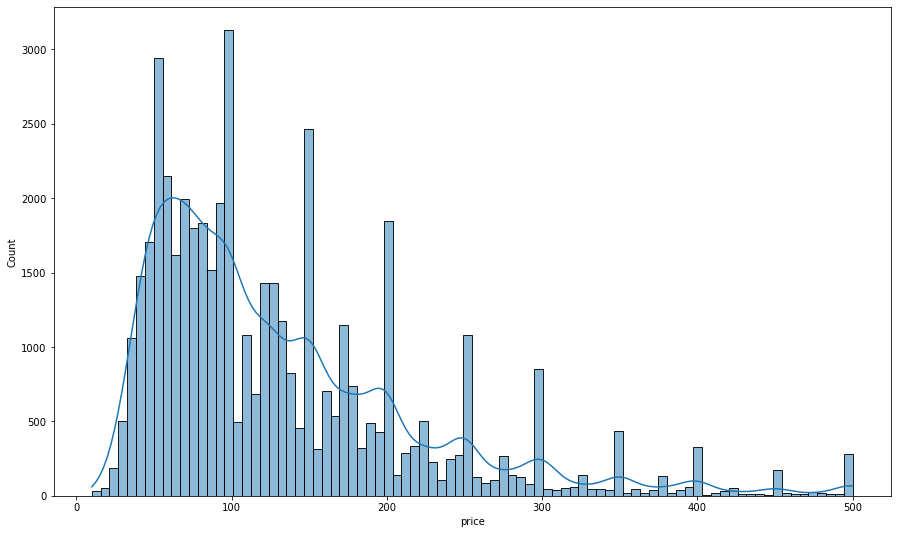

In [55]:
plt.figure(figsize=(15, 9))
sns.histplot(df.price, kde=True)

Positively skewed price distribution. Most of the lisitngs are in range 0 - 200

# Market overview

In [56]:
# todo

# Most expensive neighbourhood

In [63]:
# DataFrame grouped by neighbourhoods
df_ng = df.groupby('neighbourhood_group').agg(
                count=('price', 'count'),
                min_price=('price', 'min'),
                max_price=('price', 'max'),
                avg_price=('price', 'mean')).sort_values(by='avg_price', ascending=False).reset_index()

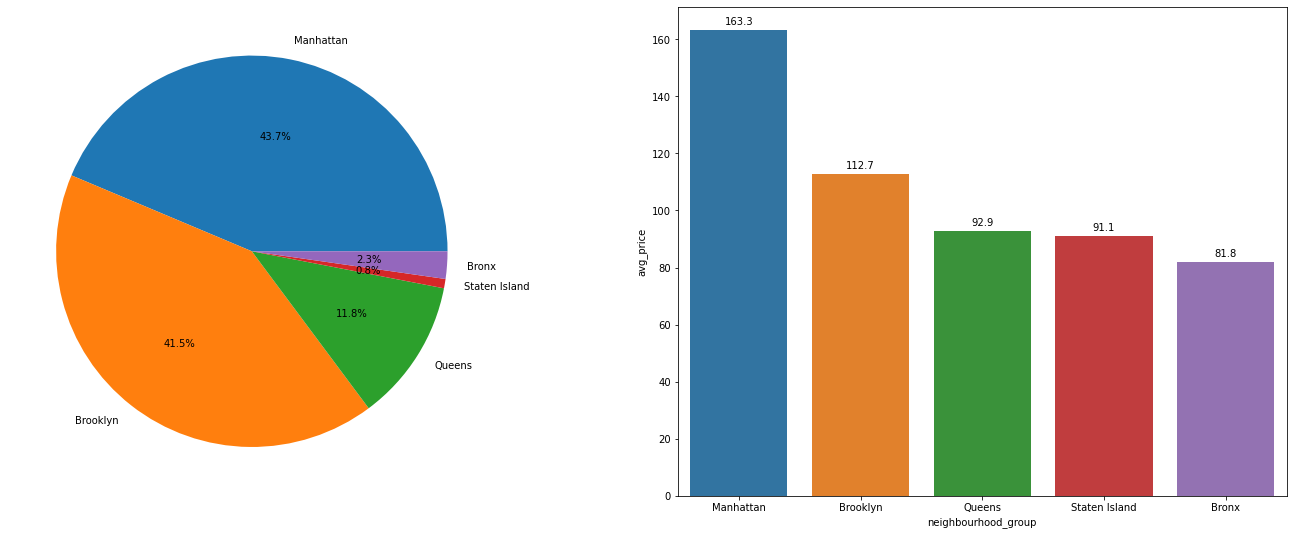

In [64]:
fig, (a1, a2) =plt.subplots(ncols=2, figsize=(24,9))
a1.pie(df_ng['count'], labels=df_ng.neighbourhood_group, autopct='%1.1f%%')
bp = sns.barplot(ax=a2, x=df_ng.neighbourhood_group, y=df_ng.avg_price)

for idx, row in df_ng.iterrows():
    bp.text(idx, row.avg_price + 2, round(row.avg_price, 1), ha='center')

Manhattan is taking biggest slice of NY city for airbnb renting and it is also has highest average price per room. Manhattan and Brooklyn together takes 85% of the market. Meanwhile Bronx has lowest average cost.

# Most expensive room type

In [66]:
df_rt = df.groupby('room_type').agg(
                count=('price', 'count'),
                avg_price=('price', 'mean')).sort_values(by='avg_price', ascending=False).reset_index()

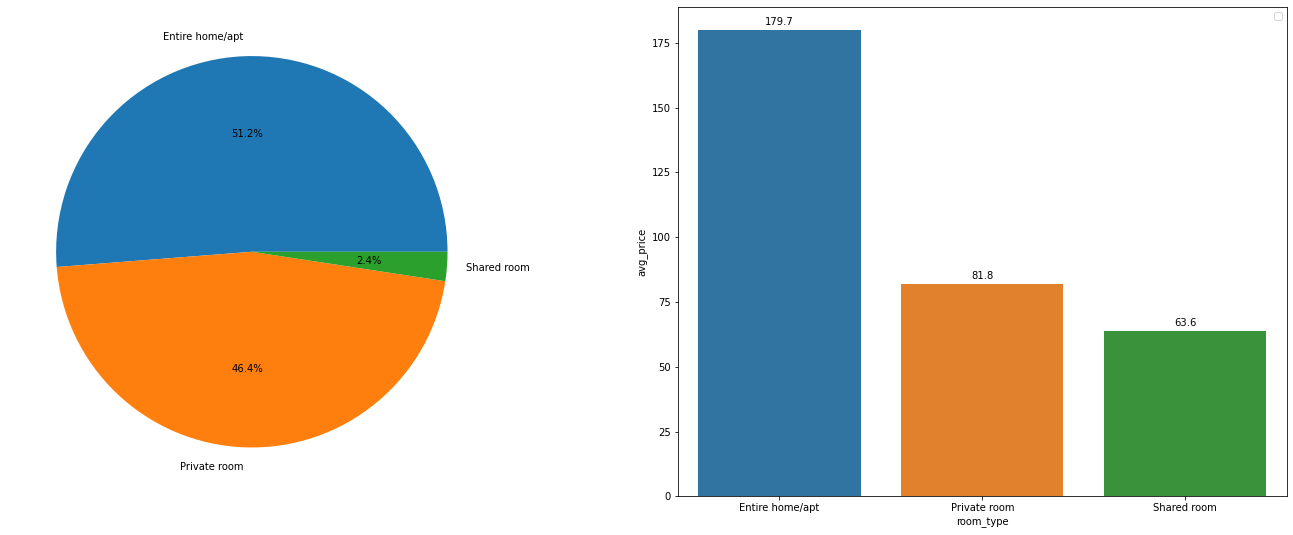

In [68]:
fig, (a1, a2) =plt.subplots(ncols=2, figsize=(24,9))
a1.pie(df_rt['count'], labels=df_rt.room_type, autopct='%1.1f%%')
bp = sns.barplot(ax=a2, x=df_rt.room_type, y=df_rt.avg_price)

for idx, row in df_rt.iterrows():
    bp.text(idx, row.avg_price + 2, round(row.avg_price, 1), ha='center')

97% of listing are either entire home/apartment or private room. Entire home is the most expensive option, on average it is twice more expensive than rernting a room, or almost 3 times more expnsive than renting a shared room. 

In [97]:
df_ng_rt = df.groupby(['neighbourhood_group', 'room_type']).agg(
                count=('price', 'count'),
                avg_price=('price', 'mean')).sort_values(by='avg_price', ascending=False).reset_index()
df_ng_rt

,neighbourhood_group,room_type,count,avg_price
0,Manhattan,Entire home/apt,12523,203.877905
1,Brooklyn,Entire home/apt,9367,159.864524
2,Queens,Entire home/apt,2078,138.751684
3,Staten Island,Entire home/apt,170,124.835294
4,Bronx,Entire home/apt,376,122.486702
5,Manhattan,Private room,7887,103.544060
6,Manhattan,Shared room,477,84.085954
7,Brooklyn,Private room,10089,71.453266
8,Queens,Private room,3364,67.020809
9,Staten Island,Private room,188,62.292553


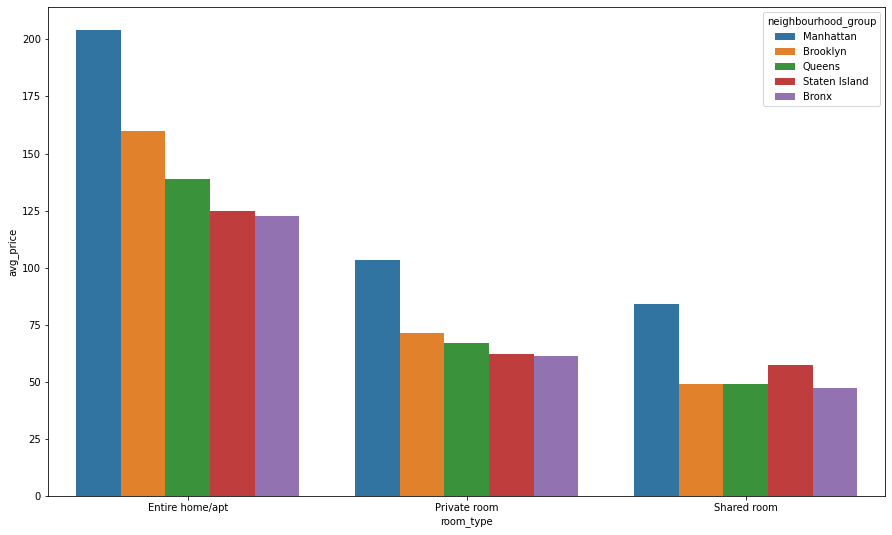

In [99]:
plt.figure(figsize=(15, 9))
sns.barplot(x=df_ng_rt.room_type, y=df_ng_rt.avg_price, hue=df_ng_rt.neighbourhood_group)

Manhattan is "dominating" pricewise. surprisingly there are not such a big difference between share room and private room pries.

# Reviews

# Top rated area

# Top rated room type

# What rooms are being rented more often